Matriz de confusão (classes reais x clusters originais):
[[ 1  0 58]
 [66  2  3]
 [ 0 48  0]]

Matriz de confusão (classes reais x clusters mapeados):
[[58  1  0]
 [ 3 66  2]
 [ 0  0 48]]

Acurácia aproximada após mapear clusters -> classes: 0.966


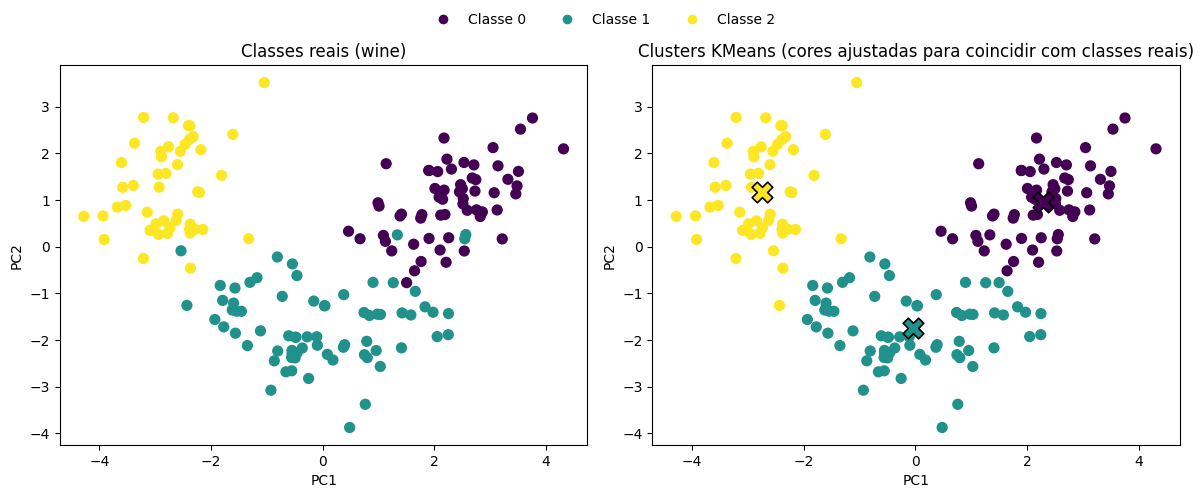

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, accuracy_score

# carregar e preparar
data = load_wine()
X = data.data
y = data.target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# KMeans nos dados projetados
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
y_kmeans = kmeans.fit_predict(X_pca)

# --- Criar mapeamento cluster -> label real (majority vote) ---
mapping = {}
for cluster in np.unique(y_kmeans):
    # pega os rótulos verdadeiros das amostras desse cluster e escolhe o mais frequente
    true_labels, counts = np.unique(y[y_kmeans == cluster], return_counts=True)
    mapping[cluster] = true_labels[np.argmax(counts)]

# aplica o mapeamento para "recolorir" os clusters segundo as classes reais
y_kmeans_mapped = np.array([mapping[c] for c in y_kmeans])

# avaliação
print("Matriz de confusão (classes reais x clusters originais):")
print(confusion_matrix(y, y_kmeans))
print("\nMatriz de confusão (classes reais x clusters mapeados):")
print(confusion_matrix(y, y_kmeans_mapped))
print(f"\nAcurácia aproximada após mapear clusters -> classes: {accuracy_score(y, y_kmeans_mapped):.3f}")

# --- Plot: manter as mesmas cores para comparação ---
cmap = plt.get_cmap("viridis", 3)  # 3 cores distintas

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# classes reais (esquerda)
sc0 = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap=cmap, s=50)
axes[0].set_title("Classes reais (wine)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# clusters KMeans mas com cores mapeadas para classes reais (direita)
sc1 = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=y_kmeans_mapped, cmap=cmap, s=50)

# desenhar centroides com a cor da classe mapeada para cada centro
centroids = kmeans.cluster_centers_
# cada centro pertence originalmente a um cluster; convertemos para a classe mapeada
centroid_mapped_labels = np.array([mapping[i] for i in range(len(centroids))])
for i, (cx, cy) in enumerate(centroids):
    lbl = centroid_mapped_labels[i]
    axes[1].scatter(cx, cy, marker='X', s=220, edgecolor='k',
                    facecolor=cmap(lbl), linewidth=1.2, zorder=5)

axes[1].set_title("Clusters KMeans (cores ajustadas para coincidir com classes reais)")
axes[1].set_xlabel("PC1")
axes[1].set_ylabel("PC2")

# legenda consistente para ambas figuras
handles = []
labels_legend = []
for class_label in np.unique(y):
    handles.append(plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=cmap(class_label), markersize=8))
    labels_legend.append(f"Classe {class_label}")

fig.legend(handles, labels_legend, loc='upper center', ncol=3, frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()